# Análise inicial dos dados da estrutura do SnSe em função da Pressão hidrostática (Explicação e extração)



O próprio Quantum Espresso fornece uma ferramenta de controle da pressão hidrostática à qual o cristal está submetido. Isso é feito por meio da tag $\textit{press}$ no card $\textit{&CELL}$


Como o interesse nesse momento está em analisar como a estrutura se comporta com a pressão hidrostática, preciso repetir o mesmo calculo para diversos $\textit{press}$ diferentes. De fato, realizei o calculo em pressões que vão de 0 a 130 Kbar (0 a 13 Gpa)com passo de 5Kbar.


Os critérios de convergência utilizados foram: 
* forc_conv_thr=1.0d-5 
* etot_conv_thr=1.0d-8
* ecutwfc = 130
* ecutrho = 650
* conv_thr =   1.0d-11
* press_conv_thr = 0.3


Ainda, o procedimento de relaxação utilizado foi de relaxação total (posições, ângulos e parâmetros de rede).
Dessa forma, ecutwfc já está aumentado em cerca de 30% e após terminada a relaxação a estrutura otimizada é tomada como ponto de partida para um segundo cálculo de relaxação total, a fim de minimizar o Pulay Stress. A estrutura que sai desse segundo cálculo é a "tomada como verdadeira".


Por fim vale ainda comentar que, a fim de minimizar o tempo total de cálculo e melhorar a convergência, a estrutura inicial utilizada no calculo com pressão P era a estrutura resultante do calculo anterior, com pressão P-5.


Abaixo, apresento os scripts adotados para a realização desses cálculos. A ideia foi usar um arquivo de base, chamado "QEinput" onde todas as flags de controle do cálculo estão contidas. Um pequeno script Shell cria a pasta onde o cálculo será feito e chama um pequeno programa "gerador.py" que copia "QEinput" para dentro dessa pasta já substituindo as flags necessárias (no caso, $\textit{&CELL}$, mas é facilmente adaptável para qualquer flag) e também já substitui a estrutura, buscando o resultado do calculo anterior. 
(DA FORMA COMO ESTÁ, O CALCULO ZERO TEM DE SER FEITO ANTES, E SÓ DEPOIS COMEÇA A AUTOMZATIZAÇÃO.

In [1]:
!cat pre-qe/QEinput


&CONTROL
  calculation = 'vc-relax'
  prefix = 'snse'
  outdir = './outdir'
  pseudo_dir = '~/pseudos/dojo'
  restart_mode='from_scratch',  verbosity = 'high'
  tprnfor = .true., tstress = .true. 
  forc_conv_thr=1.0d-5, etot_conv_thr=1.0d-8
  nstep = 200
/
&SYSTEM
  ecutwfc = 130
  ecutrho = 650
  ibrav = 0,  nat = 8,  ntyp = 2
  input_dft = 'rvv10'
/
&ELECTRONS
  conv_thr =   1.0d-11
  electron_maxstep = 150
/
&IONS
ion_dynamics='bfgs'
/
&CELL
cell_dynamics = 'bfgs'
press =
press_conv_thr = 0.3
cell_dofree = 'all'
/
ATOMIC_SPECIES
Sn     118.71   Sn.upf
Se     78.96    Se.upf
CELL_PARAMETERS (angstrom)
  11.616785005   0.000000000   0.000000000
   0.000000000   4.202921321   0.000000000
   0.000000000   0.000000000   4.384886141
ATOMIC_POSITIONS (crystal)
Sn            0.1312745291        0.2500000000        0.0700910337
Sn            0.8687254779        0.7500000000        0.9299089893
Sn            0.3687254779        0.7500000000        0.5700910107
Sn            0.6312745221     

In [2]:
!cat pre-qe/shell_gerador

for P in {5..130..5}; do
anterior=$[P-5]
DOJO=/home/des01/aantone/aguiarsm/snse/press/dojo/rvv10

cd /home/des01/aantone/aguiarsm/snse/press/dojo/rvv10

mkdir $P
cd $P

python2.7 $DOJO/gerador.py ./../$anterior/rlx2/vc-relax.out $P

mpirun -np 60 /home/des01/aantone/aguiarsm/sw/qe/670/install/bin/pw.x -npool 4 < vc-relax.in > vc-relax.out

mkdir rlx2
cd rlx2

python2.7 $DOJO/gerador.py ./../vc-relax.out $P

mpirun -np 60 /home/des01/aantone/aguiarsm/sw/qe/670/install/bin/pw.x -npool 4 < vc-relax.in > vc-relax.out

done


In [3]:
!cat ./pre-qe/gerador.py

import sys

leitura = open(sys.argv[1], 'r')
leitura2 = open('/home/des01/aantone/aguiarsm/snse/press/dojo/rvv10/QEinput', 'r')
escrita = open('vc-relax.in', 'w')
P = sys.argv[2]

for line2 in leitura2:
    if line2 == 'press =\n':
        escrita.write('press = %s\n' % P)
    elif line2 == 'CELL_PARAMETERS (angstrom)\n':
        break
    else:
        escrita.write(line2)
for line in leitura:
    if line == 'Begin final coordinates\n':
        for line in leitura:
            if line == 'CELL_PARAMETERS (angstrom)\n':
                escrita.write(line)
                for line in leitura:
                    if line == 'End final coordinates\n':
                        break
                    else:
                        escrita.write(line)
for line2 in leitura2:
    if line2 == 'K_POINTS {automatic}\n':
        escrita.write(line2)
        for line2 in leitura2:
            escrita.write(line2)
        exit()


## Realizando a extração dos dados

#### Abaixo, com o pseudopotencial do dojo e exchange-correlation rvv10

Ok! Os cálculos descritos acima já estão prontos no cluster. Agora vou trazer os resultados mais importantes pra minha máquina e começar a extrair informações.

In [1]:
#para baixar os dados, após abrir o túnel com a gate:



#   for p in {0..130..5};

#   do mkdir \$p

#   scp -P 50022 aguiarsm@localhost:~/snse/press/dojo/rvv10/$\$p$/rlx2/vc-relax.out 
#/home/murilo/Desktop/SnSe/calc/press/dojo/rvv10/$\$p
    
#done

Agora vou pegar um arquivo qualquer (P=0) para analisar a estrutura do arquivo e ver como extrair os dados de interesse (A saber: parâmetros de rede e posições atômicas). Feito isso, automatizamos o processo para os demais dados.

In [5]:
!grep "final" ./outs/0/vc-relax.out

Begin final coordinates
End final coordinates
     The G-vectors are recalculated for the final unit cell


In [6]:
!grep "Begin final" ./outs/0/vc-relax.out

Begin final coordinates


In [7]:
!grep -A 18 "Begin final" ./outs/0/vc-relax.out

Begin final coordinates
     new unit-cell volume =   1547.93942 a.u.^3 (   229.38096 Ang^3 )
     density =      5.72391 g/cm^3

CELL_PARAMETERS (angstrom)
  11.841020040   0.000000000   0.000000000
   0.000000000   4.245671614   0.000000000
   0.000000000   0.000000000   4.562699253

ATOMIC_POSITIONS (crystal)
Sn            0.1208611273        0.2500000000        0.1170180357
Sn            0.8791388797        0.7500000000        0.8829819873
Sn            0.3791388797        0.7500000000        0.6170180127
Sn            0.6208611203        0.2500000000        0.3829819573
Se            0.8558566833        0.2500000000        0.4717308200
Se            0.1441433167        0.7500000000        0.5282691500
Se            0.6441433167        0.7500000000        0.9717308500
Se            0.3558566833        0.2500000000        0.0282691800
End final coordinates


In [8]:
!grep -A 18 "Begin final" ./outs/0/vc-relax.out >> teste.txt

OK! funcionou! Fazendo para todos

In [9]:
!for i in {0..130..5}; do cd ./outs/$i; grep -A 18 "Begin final" ./vc-relax.out > estrutura.txt; cd ./../..; done 

In [10]:
!cat outs/0/estrutura.txt #verificando

Begin final coordinates
     new unit-cell volume =   1547.93942 a.u.^3 (   229.38096 Ang^3 )
     density =      5.72391 g/cm^3

CELL_PARAMETERS (angstrom)
  11.841020040   0.000000000   0.000000000
   0.000000000   4.245671614   0.000000000
   0.000000000   0.000000000   4.562699253

ATOMIC_POSITIONS (crystal)
Sn            0.1208611273        0.2500000000        0.1170180357
Sn            0.8791388797        0.7500000000        0.8829819873
Sn            0.3791388797        0.7500000000        0.6170180127
Sn            0.6208611203        0.2500000000        0.3829819573
Se            0.8558566833        0.2500000000        0.4717308200
Se            0.1441433167        0.7500000000        0.5282691500
Se            0.6441433167        0.7500000000        0.9717308500
Se            0.3558566833        0.2500000000        0.0282691800
End final coordinates


In [11]:
!cat outs/60/estrutura.txt

Begin final coordinates
     new unit-cell volume =   1349.76161 a.u.^3 (   200.01404 Ang^3 )
     density =      6.56431 g/cm^3

CELL_PARAMETERS (angstrom)
  11.312107954   0.000000000   0.000000000
   0.000000000   4.159922349   0.000000000
   0.000000000   0.000000000   4.250418631

ATOMIC_POSITIONS (crystal)
Sn            0.1174449151        0.2500000000        0.0667459451
Sn            0.8825550919        0.7500000000        0.9332540779
Sn            0.3825550919        0.7500000000        0.5667459221
Sn            0.6174449081        0.2500000000        0.4332540479
Se            0.8599645322        0.2500000000        0.4815166978
Se            0.1400354678        0.7500000000        0.5184832722
Se            0.6400354678        0.7500000000        0.9815167278
Se            0.3599645322        0.2500000000        0.0184833022
End final coordinates


Estrutura que vou organizar esses dados serão:

Pressao;volume;densidade;a;b;c;sn1a;sn1b;sn1c;sn2a;sn2b;sn2c;sn3a;sn3b;sn3c;sn4a;sn4b;sn4c;se1a;se1b;se1c;
se2a;se2b;se2c;se3a;se3b;se3c;se4a;se4b;se4c

In [12]:
#teste de estrutura
LEITURA = open("outs/0/estrutura.txt", "r")

for j, line in enumerate(LEITURA):
    print(j, line)
    
LEITURA.close()

0 Begin final coordinates

1      new unit-cell volume =   1547.93942 a.u.^3 (   229.38096 Ang^3 )

2      density =      5.72391 g/cm^3

3 

4 CELL_PARAMETERS (angstrom)

5   11.841020040   0.000000000   0.000000000

6    0.000000000   4.245671614   0.000000000

7    0.000000000   0.000000000   4.562699253

8 

9 ATOMIC_POSITIONS (crystal)

10 Sn            0.1208611273        0.2500000000        0.1170180357

11 Sn            0.8791388797        0.7500000000        0.8829819873

12 Sn            0.3791388797        0.7500000000        0.6170180127

13 Sn            0.6208611203        0.2500000000        0.3829819573

14 Se            0.8558566833        0.2500000000        0.4717308200

15 Se            0.1441433167        0.7500000000        0.5282691500

16 Se            0.6441433167        0.7500000000        0.9717308500

17 Se            0.3558566833        0.2500000000        0.0282691800

18 End final coordinates



In [13]:
#teste de estrutura

LEITURA = open("outs/0/estrutura.txt", "r")
ESCRITA = open("struct_press_data", "w")
prov = []

for j, line in enumerate(LEITURA):
    line = line.strip().split()
    print(j, line)
    prov.append(line)
    
LEITURA.close()
ESCRITA.close()

0 ['Begin', 'final', 'coordinates']
1 ['new', 'unit-cell', 'volume', '=', '1547.93942', 'a.u.^3', '(', '229.38096', 'Ang^3', ')']
2 ['density', '=', '5.72391', 'g/cm^3']
3 []
4 ['CELL_PARAMETERS', '(angstrom)']
5 ['11.841020040', '0.000000000', '0.000000000']
6 ['0.000000000', '4.245671614', '0.000000000']
7 ['0.000000000', '0.000000000', '4.562699253']
8 []
9 ['ATOMIC_POSITIONS', '(crystal)']
10 ['Sn', '0.1208611273', '0.2500000000', '0.1170180357']
11 ['Sn', '0.8791388797', '0.7500000000', '0.8829819873']
12 ['Sn', '0.3791388797', '0.7500000000', '0.6170180127']
13 ['Sn', '0.6208611203', '0.2500000000', '0.3829819573']
14 ['Se', '0.8558566833', '0.2500000000', '0.4717308200']
15 ['Se', '0.1441433167', '0.7500000000', '0.5282691500']
16 ['Se', '0.6441433167', '0.7500000000', '0.9717308500']
17 ['Se', '0.3558566833', '0.2500000000', '0.0282691800']
18 ['End', 'final', 'coordinates']


In [14]:
print(prov[0])

['Begin', 'final', 'coordinates']


In [15]:
print(prov[1])

['new', 'unit-cell', 'volume', '=', '1547.93942', 'a.u.^3', '(', '229.38096', 'Ang^3', ')']


Ok! Agora ficou fácil mapear!!!

In [16]:
volume = float(prov[1][4])
desidade = float(prov[2][2])
a = float(prov[5][0])
b = float(prov[6][1])
c = float(prov[7][2])
sn1a = float(prov[10][1])
sn1b = float(prov[10][2])
sn1c = float(prov[10][3])

sn2a = float(prov[11][1])
sn2b = float(prov[11][2])
sn2c = float(prov[11][3])

sn3a = float(prov[12][1])
sn3b = float(prov[12][2])
sn3c = float(prov[12][3])

sn4a = float(prov[13][1])
sn4b = float(prov[13][2])
sn4c = float(prov[13][3])

se1a = float(prov[14][1])
se1b = float(prov[14][2])
se1c = float(prov[14][3])

se2a = float(prov[15][1])
se2b = float(prov[15][2])
se2c = float(prov[15][3])

se3a = float(prov[16][1])
se3b = float(prov[16][2])
se3c = float(prov[16][3])

se4a = float(prov[17][1])
se4b = float(prov[17][2])
se4c = float(prov[17][3])

In [17]:
sn3c

0.6170180127

ok! Com isso é só escrever no arquivo agora. Generalizando para todos, sai o programa abaixo.

In [18]:


def pega_instancia(arquivo):
    """Gera o vetor com os dados em suas devidas posições"""
    
    
    LEITURA = open(arquivo, "r")
    prov = []
    
    for j, line in enumerate(LEITURA):
        line = line.strip().split()
        prov.append(line)
    
    LEITURA.close()
    return prov


ESCRITA = open("struct_press_data", "w")
range_press = [i for i in range(0,131,5)]

for j, i in enumerate(range_press):
    caminho = "./outs/"+str(i)+"/"+"estrutura.txt"
    prov = pega_instancia(caminho)
    volume = float(prov[1][7])
    densidade = float(prov[2][2])
    a = float(prov[5][0])
    b = float(prov[6][1])
    c = float(prov[7][2])
    sn1a = float(prov[10][1])
    sn1b = float(prov[10][2])
    sn1c = float(prov[10][3])
    sn2a = float(prov[11][1])
    sn2b = float(prov[11][2])
    sn2c = float(prov[11][3])
    sn3a = float(prov[12][1])
    sn3b = float(prov[12][2])
    sn3c = float(prov[12][3])
    sn4a = float(prov[13][1])
    sn4b = float(prov[13][2])
    sn4c = float(prov[13][3])
    se1a = float(prov[14][1])
    se1b = float(prov[14][2])
    se1c = float(prov[14][3])
    se2a = float(prov[15][1])
    se2b = float(prov[15][2])
    se2c = float(prov[15][3])
    se3a = float(prov[16][1])
    se3b = float(prov[16][2])
    se3c = float(prov[16][3])
    se4a = float(prov[17][1])
    se4b = float(prov[17][2])
    se4c = float(prov[17][3])    
    if j == 0:
        ESCRITA.write("pressao(Kbar),volume(Ang^3),densidade(g/cm^3),a,b,c,\
sn1a,sn1b,sn1c,sn2a,sn2b,sn2c,sn3a,sn3b,sn3c,sn4a,sn4b,sn4c,\
se1a,se1b,se1c,se2a,se2b,se2c,se3a,se3b,se3c,se4a,se4b,se4c\n")
        
        ESCRITA.write(f"{i},{volume},{densidade},{a},{b},{c},\
        {sn1a},{sn1b},{sn1c},{sn2a},{sn2b},{sn2c},{sn3a},{sn3b},{sn3c},{sn4a},{sn4b},{sn4c},\
        {se1a},{se1b},{se1c},{se2a},{se2b},{se2c},{se3a},{se3b},{se3c},{se4a},{se4b},{se4c}\n") 
    else:
        ESCRITA.write(f"{i},{volume},{densidade},{a},{b},{c},\
        {sn1a},{sn1b},{sn1c},{sn2a},{sn2b},{sn2c},{sn3a},{sn3b},{sn3c},{sn4a},{sn4b},{sn4c},\
        {se1a},{se1b},{se1c},{se2a},{se2b},{se2c},{se3a},{se3b},{se3c},{se4a},{se4b},{se4c}\n")        
    
ESCRITA.close()

Agora os dados já estão filtrados. É só trabalhar com eles.

In [19]:
import pandas as pd

df = pd.read_csv("struct_press_data")
df

,pressao(Kbar),volume(Ang^3),densidade(g/cm^3),a,b,c,sn1a,sn1b,sn1c,sn2a,...,se1c,se2a,se2b,se2c,se3a,se3b,se3c,se4a,se4b,se4c
0,0,229.38096,5.72391,11.841020,4.245672,4.562699,0.120861,0.25,0.117018,0.879139,...,0.471731,0.144143,0.75,0.528269,0.644143,0.75,0.971731,0.355857,0.25,0.028269
1,5,225.85806,5.81319,11.777786,4.238252,4.524652,0.120270,0.25,0.112793,0.879730,...,0.471977,0.143595,0.75,0.528023,0.643595,0.75,0.971977,0.356405,0.25,0.028023
2,10,222.54109,5.89983,11.722103,4.229405,4.488750,0.119555,0.25,0.108662,0.880445,...,0.472428,0.143437,0.75,0.527572,0.643437,0.75,0.972428,0.356563,0.25,0.027572
3,15,219.52263,5.98096,11.668725,4.220857,4.457130,0.119059,0.25,0.104774,0.880941,...,0.472795,0.143079,0.75,0.527205,0.643079,0.75,0.972795,0.356921,0.25,0.027205
4,20,216.73088,6.05800,11.618783,4.213155,4.427440,0.118678,0.25,0.100722,0.881322,...,0.473360,0.142693,0.75,0.526640,0.642693,0.75,0.973360,0.357307,0.25,0.026640
5,25,214.14188,6.13124,11.571708,4.205927,4.399896,0.118397,0.25,0.096606,0.881603,...,0.474062,0.142274,0.75,0.525938,0.642274,0.75,0.974062,0.357726,0.25,0.025938
6,30,211.73269,6.20100,11.527526,4.199151,4.374117,0.118200,0.25,0.092357,0.881800,...,0.474920,0.141843,0.75,0.525080,0.641843,0.75,0.974920,0.358157,0.25,0.025080
7,35,209.47611,6.26780,11.485782,4.192652,4.349958,0.118049,0.25,0.087995,0.881951,...,0.475961,0.141433,0.75,0.524039,0.641433,0.75,0.975961,0.358567,0.25,0.024039
8,40,207.36075,6.33174,11.446823,4.186260,4.327284,0.117921,0.25,0.083534,0.882079,...,0.477148,0.141072,0.75,0.522852,0.641072,0.75,0.977148,0.358928,0.25,0.022852
9,45,205.36756,6.39320,11.410177,4.179846,4.306051,0.117799,0.25,0.079113,0.882201,...,0.478369,0.140761,0.75,0.521631,0.640761,0.75,0.978369,0.359239,0.25,0.021631


In [20]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

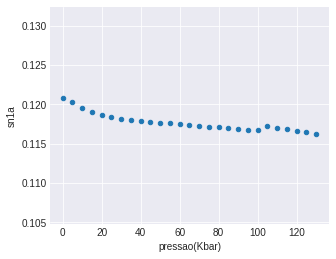

In [21]:
df.plot.scatter(x="pressao(Kbar)",y="sn1a", figsize=(5,4))

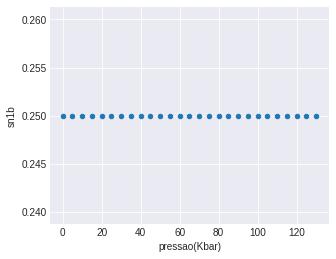

In [22]:
df.plot.scatter(x="pressao(Kbar)", y="sn1b", figsize=(5,4))

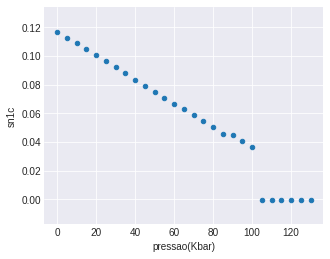

In [23]:
df.plot.scatter(x="pressao(Kbar)", y="sn1c", figsize=(5,4))

OLHA AI A TRANSIÇÃO DE FASE!!!!! Vamos ver pro Se:

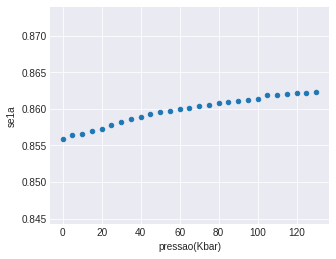

In [24]:
df.plot.scatter(x="pressao(Kbar)", y="se1a", figsize=(5,4))

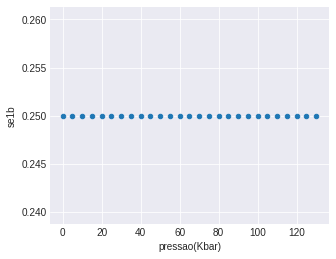

In [25]:
df.plot.scatter(x="pressao(Kbar)", y="se1b", figsize=(5,4))

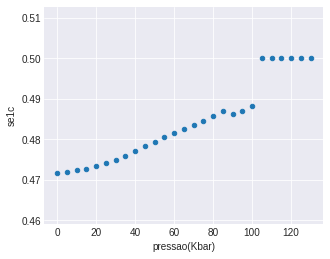

In [26]:
df.plot.scatter(x="pressao(Kbar)", y="se1c", figsize=(5,4))

Ai está! Ela acontece em torno de 10 GPa de pressao. Bem próximo dos resultados experimentais disponíveis.

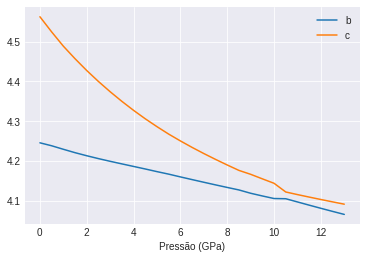

In [27]:
import numpy as np

#plt.plot(df["pressao"].to_numpy(), df["a"].to_numpy(), label="a")
#A direcao "a" é a perpendicular às camadas
plt.figure(figsize=(6,4))
plt.plot(df["pressao(Kbar)"].to_numpy()/10, df["b"].to_numpy(), label="b")
plt.plot(df["pressao(Kbar)"].to_numpy()/10, df["c"].to_numpy(), label="c")
plt.xlabel("Pressão (GPa)")
plt.legend()
plt.show()

Vamos ver a equação de estado comparando com os dados experimentais.

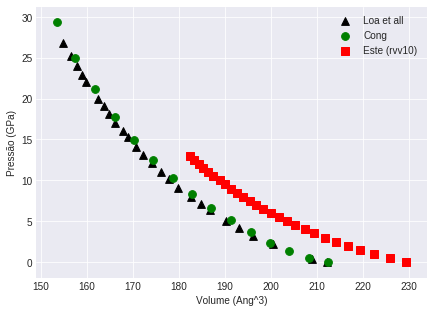

In [28]:
def gera_dados(ARQUIVO):
    x, y = [], []
    for linha in open(ARQUIVO, "r"):
        dados = [float(j) for j in linha.split()]
        x.append(dados[0])
        y.append(dados[1])
    return x, y


plt.figure(figsize=(7,5))

volume, pressao = gera_dados("./../../LOA_PV.csv")
plt.scatter(volume, pressao, label="Loa et all", marker="^", c="black", s=60)

volume, pressao = gera_dados("./../../CONG_PV.csv")
plt.scatter(volume, pressao, label="Cong", marker="o", c="green", s=60)

plt.scatter(df["volume(Ang^3)"].to_numpy(), df["pressao(Kbar)"].to_numpy()/10,\
            label="Este (rvv10)", marker="s", c="red", s=60)    

plt.xlabel("Volume (Ang^3)")
plt.ylabel("Pressão (GPa)")
plt.legend()

plt.show()